In [34]:
scores = '../out/ko_scores.txt'
dev = '../out/deviating.tsv'
sgd = '../out/SGD_features.tab'
biogrid = '../out/biogrid.all.txt'
biogrid_genetic = '../out/biogrid.genetic.txt'

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib_venn import venn2, venn3

sns.set_style('white')

plt.rc('font', size=11)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rc('axes', labelsize=12, titlesize=12)
plt.rc('legend', fontsize=11)

In [37]:
import random
import numpy as np
import pandas as pd
import networkx as nx
from scipy import stats

In [4]:
it = {}
for l in open(biogrid):
    g1, g2 = l.rstrip().split()
    it[g1] = it.get(g1, 0)
    it[g2] = it.get(g2, 0)
    it[g1] += 1
    it[g2] += 1

In [5]:
bg = nx.Graph()
for l in open(biogrid):
    g1, g2 = l.rstrip().split()
    bg.add_edge(g1, g2)
bc = nx.betweenness_centrality(bg, k=500)

In [6]:
g = pd.read_table(sgd, sep='\t', header=None)
gn = g[g[1] == 'ORF'].set_index(3)[4].dropna().to_dict()
gd = g[g[1] == 'ORF'].set_index(3)[15].dropna().to_dict()

In [105]:
gi = pd.read_table(biogrid_genetic)
git = {}
for g1, g2 in gi[(gi['interaction'] == 'negative') &
                 (gi['count'] >= 2)][['gene1', 'gene2']].values:
    git[g1] = git.get(g1, 0)
    git[g2] = git.get(g2, 0)
    git[g1] += 1
    git[g2] += 1
pit = {}
for g1, g2 in gi[(gi['interaction'] == 'positive') &
                 (gi['count'] >= 2)][['gene1', 'gene2']].values:
    pit[g1] = pit.get(g1, 0)
    pit[g2] = pit.get(g2, 0)
    pit[g1] += 1
    pit[g2] += 1

In [7]:
m = pd.read_table(scores, index_col=[0, 2, 1])
m['phenotype'] = m['qvalue'] < 0.05
genes = None
for s in {x[0] for x in m.index}:
    gs = {x[0] for x in m.loc[s].index}
    if genes is None:
        genes = gs
    else:
        genes = genes.intersection(gs)
    print(s, len(gs))
print('')
print('total', len(genes))
genes = sorted(genes)
p = m.reset_index().set_index('gene').loc[genes].groupby('condition').sum()['phenotype']

Y55 4190
UWOP 4014
YPS 4093
S288C 4889

total 3786


In [8]:
d = pd.read_table(dev, index_col=[4, 5, 1, 0])
d = d.loc[(slice(None), slice(None), genes),]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1367: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


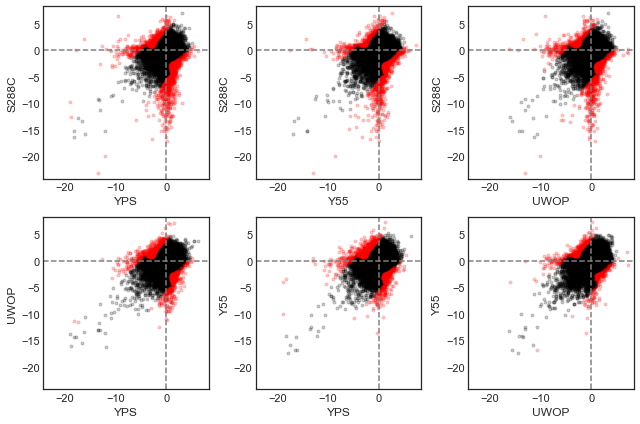

In [9]:
plt.figure(figsize=(9, 6))

vmin = min([d['scores1'].min(),
            d['scores2'].min()]) - 1
vmax = min([d['scores1'].max(),
            d['scores2'].max()]) + 1

ss = {tuple(x[:2])
      for x in d.index}
ss = sorted(ss, key=lambda x: x[1])

i = 1
for s1, s2 in ss:
    plt.subplot(2, 3, i)
    
    x = d.loc[(s1, s2),]
    plt.plot(x[x['qval'] >= 1E-2]['scores1'],
             x[x['qval'] >= 1E-2]['scores2'],
             'k.',
             alpha=0.2)
    plt.plot(x[x['qval'] < 1E-2]['scores1'],
             x[x['qval'] < 1E-2]['scores2'],
             'r.',
             alpha=0.2)
    
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    
    plt.axhline(0,
                color='grey',
                linestyle='dashed')
    plt.axvline(0,
                color='grey',
                linestyle='dashed')
    
    plt.xlabel(s1)
    plt.ylabel(s2)
    
    i += 1

plt.tight_layout();

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1367: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


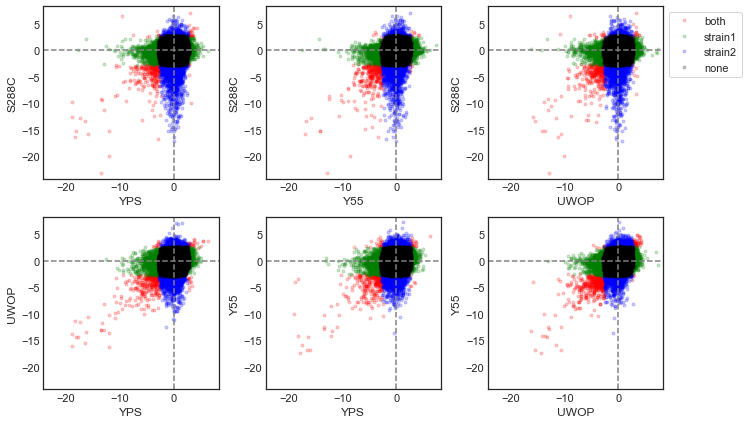

In [13]:
plt.figure(figsize=(10.5, 6))

vmin = min([d['scores1'].min(),
            d['scores2'].min()]) - 1
vmax = min([d['scores1'].max(),
            d['scores2'].max()]) + 1

ss = {tuple(x[:2])
      for x in d.index}
ss = sorted(ss, key=lambda x: x[1])

i = 1
for s1, s2 in ss:
    plt.subplot(2, 3, i)
    
    label1 = 'both'
    label2 = 'strain1'
    label3 = 'strain2'
    label4 = 'none'
    
    x = d.loc[(s1, s2),]
    plt.plot(x[x['phenotype1'] & x['phenotype2']]['scores1'],
             x[x['phenotype1'] & x['phenotype2']]['scores2'],
             'r.',
             alpha=0.2,
             label=label1)
    plt.plot(x[x['phenotype1'] & np.invert(x['phenotype2'])]['scores1'],
             x[x['phenotype1'] & np.invert(x['phenotype2'])]['scores2'],
             'g.',
             alpha=0.2,
             label=label2)
    plt.plot(x[x['phenotype2'] & np.invert(x['phenotype1'])]['scores1'],
             x[x['phenotype2'] & np.invert(x['phenotype1'])]['scores2'],
             'b.',
             alpha=0.2,
             label=label3)
    plt.plot(x[np.invert(x['phenotype1']) & np.invert(x['phenotype2'])]['scores1'],
             x[np.invert(x['phenotype1']) & np.invert(x['phenotype2'])]['scores2'],
             'k.',
             alpha=0.2,
             label=label4)
    
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    
    if i ==3:
        plt.legend(loc='upper left',
                   bbox_to_anchor=(1, 1),
                   frameon=True)
    
    plt.axhline(0,
                color='grey',
                linestyle='dashed')
    plt.axvline(0,
                color='grey',
                linestyle='dashed')
    
    plt.xlabel(s1)
    plt.ylabel(s2)
    
    i += 1

plt.tight_layout();

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1367: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


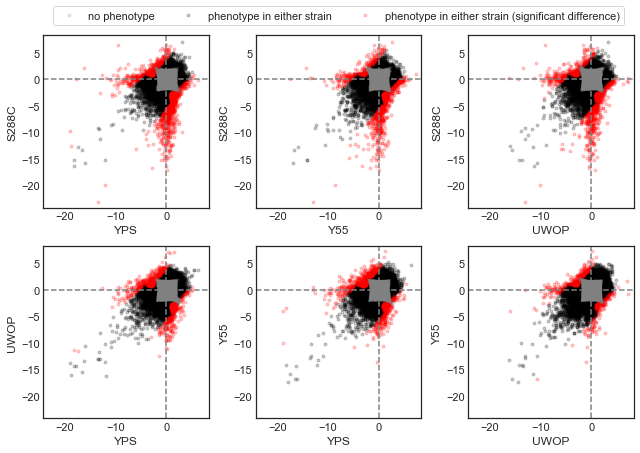

In [24]:
plt.figure(figsize=(9, 6))

vmin = min([d['scores1'].min(),
            d['scores2'].min()]) - 1
vmax = min([d['scores1'].max(),
            d['scores2'].max()]) + 1

ss = {tuple(x[:2])
      for x in d.index}
ss = sorted(ss, key=lambda x: x[1])

i = 1
for s1, s2 in ss:
    if i == 2:
        ax = plt.subplot(2, 3, i)
    else:
        plt.subplot(2, 3, i)
    
    label = 'no phenotype'
    label1 = 'phenotype in either strain'
    label2 = 'phenotype in either strain (significant difference)'
    
    x = d.loc[(s1, s2),]
    plt.plot(x[np.invert(x['phenotype1']) & np.invert(x['phenotype2'])]['scores1'],
             x[np.invert(x['phenotype1']) & np.invert(x['phenotype2'])]['scores2'],
             '.',
             color='grey',
             alpha=0.2,
             label=label)
    plt.plot(x[(x['qval'] >= 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores1'],
             x[(x['qval'] >= 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores2'],
             'k.',
             alpha=0.2,
             label=label1)
    plt.plot(x[(x['qval'] < 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores1'],
             x[(x['qval'] < 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores2'],
             'r.',
             alpha=0.2,
             label=label2)
    
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    
    plt.axhline(0,
                color='grey',
                linestyle='dashed')
    plt.axvline(0,
                color='grey',
                linestyle='dashed')
    
    plt.xlabel(s1)
    plt.ylabel(s2)
    
    i += 1

plt.tight_layout()
ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, 1.2),
          frameon=True,
          ncol=3);

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1367: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


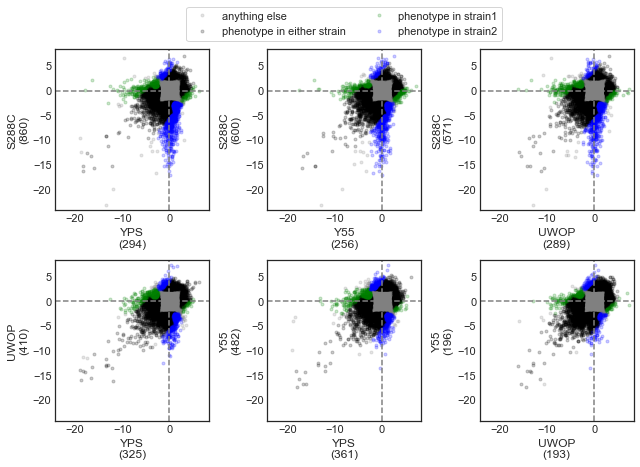

In [25]:
plt.figure(figsize=(9, 6))

vmin = min([d['scores1'].min(),
            d['scores2'].min()]) - 1
vmax = min([d['scores1'].max(),
            d['scores2'].max()]) + 1

ss = {tuple(x[:2])
      for x in d.index}
ss = sorted(ss, key=lambda x: x[1])

i = 1
for s1, s2 in ss:
    if i == 2:
        ax = plt.subplot(2, 3, i)
    else:
        plt.subplot(2, 3, i)
    
    label = 'anything else'
    label1 = 'phenotype in either strain'
    label2 = 'phenotype in strain1'
    label3 = 'phenotype in strain2'
    
    x = d.loc[(s1, s2),]
    idx1 = set(x[(x['qval'] >= 1E-2) & (x['phenotype1'] | x['phenotype2'])].index)
    idx2 = set(x[(x['qval'] < 1E-2) & (x['phenotype1'] & np.invert(x['phenotype2']))].index)
    idx3 = set(x[(x['qval'] < 1E-2) & (x['phenotype2'] & np.invert(x['phenotype1']))].index)
    idx = sorted(set(x.index) - idx1 - idx2 - idx3)
    plt.plot(x.loc[idx]['scores1'],
             x.loc[idx]['scores2'],
             '.',
             color='grey',
             alpha=0.2,
             label=label)
    plt.plot(x[(x['qval'] >= 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores1'],
             x[(x['qval'] >= 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores2'],
             'k.',
             alpha=0.2,
             label=label1)
    plt.plot(x[(x['qval'] < 1E-2) & (x['phenotype1'] & np.invert(x['phenotype2']))]['scores1'],
             x[(x['qval'] < 1E-2) & (x['phenotype1'] & np.invert(x['phenotype2']))]['scores2'],
             'g.',
             alpha=0.2,
             label=label2)
    plt.plot(x[(x['qval'] < 1E-2) & (x['phenotype2'] & np.invert(x['phenotype1']))]['scores1'],
             x[(x['qval'] < 1E-2) & (x['phenotype2'] & np.invert(x['phenotype1']))]['scores2'],
             'b.',
             alpha=0.2,
             label=label3)
    
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    
    plt.axhline(0,
                color='grey',
                linestyle='dashed')
    plt.axvline(0,
                color='grey',
                linestyle='dashed')
    
    plt.xlabel('%s\n(%d)' % (s1, len(idx2)))
    plt.ylabel('%s\n(%d)' % (s2, len(idx3)))
        
    i += 1

plt.tight_layout()

ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, 1.3),
          frameon=True,
          ncol=2);

In [26]:
res = []
for s1, s2 in {tuple(x[:2])
               for x in d.index}:
    v = d[d['phenotype1'] | d['phenotype2']].loc[(s1, s2),]
    idx = set(v.index)
    idx1 = set(v[v['phenotype1'] & np.invert(v['phenotype2']) & (v['qval'] < 1E-2)].index)
    idx2 = set(v[v['phenotype2'] & np.invert(v['phenotype1']) & (v['qval'] < 1E-2)].index)
    # switches
    idx3 = set(v[v['phenotype1'] & v['phenotype2'] & (v['qval'] < 1E-2)].index)
    idx = idx - idx1 - idx2 - idx3
    idx1 = idx1 - idx3
    idx2 = idx2 - idx3
    res.append(([len(idx1), len(idx), len(idx2), len(idx3)], [s1, s2]))

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1367: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [27]:
strains = {y
           for x in d.index
           for y in x[:2]}
palette = sns.color_palette('Set1', len(strains))
cstrains = {x: c
            for x,c in zip(strains, palette)}

/usr/local/lib/python3.6/dist-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


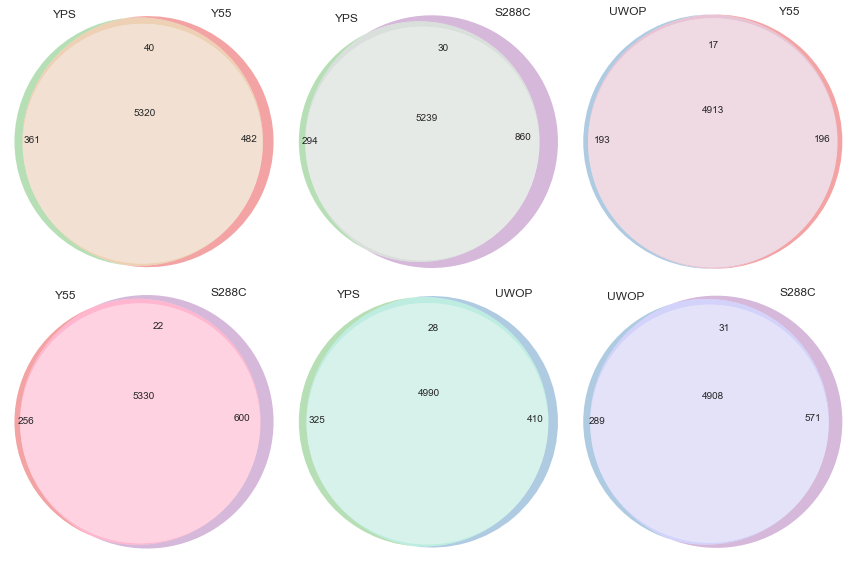

In [28]:
plt.figure(figsize=(12, 8))

for i, t in enumerate(res):
    plt.subplot(2, 3, i+1)
    
    (vs1, vs, vs2, vs3), (s1, s2) = t
    
    _ = venn3([vs1, vs2, vs3,
               0, 0, 0, vs],
              [s1, s2, ''],
              normalize_to=10,
              set_colors=[cstrains[s1],
                          cstrains[s2],
                          'w'])
plt.tight_layout()

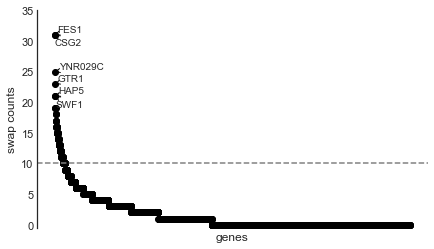

In [29]:
v = d.reset_index().set_index('gene').loc[genes]
v = v[v['qval'] < 0.01].groupby('gene').count()['qval'].sort_values(ascending=False)
v = v.reindex(genes)
v[np.isnan(v)] = 0.
v = v.sort_values(ascending=False)
idx = v.index

plt.figure(figsize=(7, 4))

plt.plot(range(v.shape[0]),
         v,
         'ko')

plt.axhline(10,
            linestyle='dashed',
            color='grey')

plt.ylim(-0.5, 35)

texts = [plt.text(i, y, gn.get(x, x),
                  ha='left',
                  va='center')
         for i,(x,y) in enumerate(v[v > 20].iteritems())]
adjust_text(texts,
            arrowprops=dict(arrowstyle='->',
                            color='k'),
            force_text=1.5)

plt.xticks([])
plt.ylabel('swap counts')
plt.xlabel('genes')
sns.despine(bottom=True);

In [30]:
res = []
t = 10
for g in v[v >= t].index:
    res.append(('above', it.get(g, 0)))
for g in v[v < t].sample(v[v >= t].shape[0]).index:
    res.append(('below', it.get(g, 0)))
igenes = sorted(gn.keys())
for i in range(5):
    random.shuffle(igenes)
    for g in igenes[:v[v >= t].shape[0]]:
        res.append(('random%d' % i, it.get(g, 0)))
r = pd.DataFrame(res,
                 columns=['set', 'interactions'])

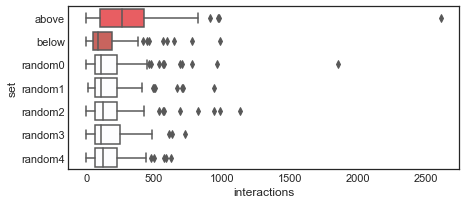

In [31]:
plt.figure(figsize=(7, 3))

sns.boxplot(data=r,
            x='interactions',
            y='set',
            palette=[sns.xkcd_rgb['light red'],
                     sns.xkcd_rgb['pale red']] + 
                    [sns.xkcd_rgb['pale grey']] * 5);

In [32]:
res = []
t = 10
for g in v[v >= t].index:
    res.append(('above', bc.get(g, 0)))
for g in v[v < t].sample(v[v >= t].shape[0]).index:
    res.append(('below', bc.get(g, 0)))
igenes = sorted(gn.keys())
for i in range(5):
    random.shuffle(igenes)
    for g in igenes[:v[v >= t].shape[0]]:
        res.append(('random%d' % i, bc.get(g, 0)))
r = pd.DataFrame(res,
                 columns=['set', 'interactions'])

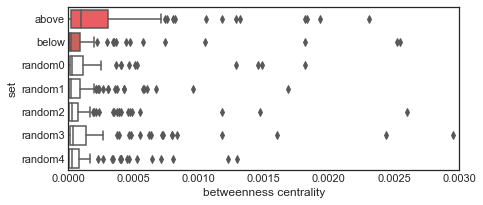

In [33]:
plt.figure(figsize=(7, 3))

sns.boxplot(data=r,
            x='interactions',
            y='set',
            palette=[sns.xkcd_rgb['light red'],
                     sns.xkcd_rgb['pale red']] + 
                    [sns.xkcd_rgb['pale grey']] * 5)
plt.xlim(0, 0.003)
plt.xlabel('betweenness centrality');

In [106]:
res = []
t = 10
for g in v[v >= t].index:
    res.append(('above', git.get(g, 0)))
for g in v[v < t].sample(v[v >= t].shape[0]).index:
    res.append(('below', git.get(g, 0)))
igenes = sorted(gn.keys())
for i in range(5):
    random.shuffle(igenes)
    for g in igenes[:v[v >= t].shape[0]]:
        res.append(('random%d' % i, git.get(g, 0)))
r = pd.DataFrame(res,
                 columns=['set', 'interactions'])

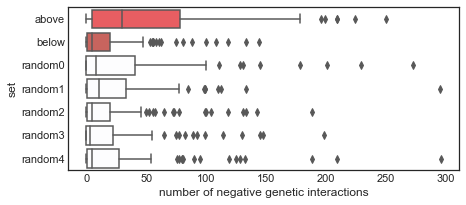

In [107]:
plt.figure(figsize=(7, 3))

sns.boxplot(data=r,
            x='interactions',
            y='set',
            palette=[sns.xkcd_rgb['light red'],
                     sns.xkcd_rgb['pale red']] + 
                    [sns.xkcd_rgb['pale grey']] * 5)
plt.xlabel('number of negative genetic interactions');

In [108]:
res = []
t = 10
for g in v[v >= t].index:
    res.append(('above', pit.get(g, 0)))
for g in v[v < t].sample(v[v >= t].shape[0]).index:
    res.append(('below', pit.get(g, 0)))
igenes = sorted(gn.keys())
for i in range(5):
    random.shuffle(igenes)
    for g in igenes[:v[v >= t].shape[0]]:
        res.append(('random%d' % i, pit.get(g, 0)))
r = pd.DataFrame(res,
                 columns=['set', 'interactions'])

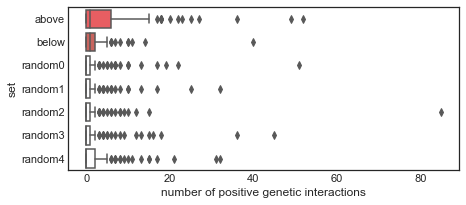

In [109]:
plt.figure(figsize=(7, 3))

sns.boxplot(data=r,
            x='interactions',
            y='set',
            palette=[sns.xkcd_rgb['light red'],
                     sns.xkcd_rgb['pale red']] + 
                    [sns.xkcd_rgb['pale grey']] * 5)
plt.xlabel('number of positive genetic interactions');

In [91]:
# enrichment in negative interactions
enr = []
for studies in range(9):
    neg = set()
    for g1, g2 in gi[(gi['interaction'] == 'negative') &
                     (gi['count'] > studies)][['gene1', 'gene2']].values:
        neg.add(g1)
        neg.add(g2)
    pos = set()
    for g1, g2 in gi[(gi['interaction'] == 'positive') &
                     (gi['count'] > studies)][['gene1', 'gene2']].values:
        pos.add(g1)
        pos.add(g2)
    for count in [5, 10, 15]:
        table = [[len(v[v > count].index.intersection(neg)),
                  len(v[v <= count].index.intersection(neg))],
                 [len(v[v > count].index.difference(neg)),
                  len(v[v <= count].index.difference(neg))]]
        enr.append(('negative',
                    studies, count,
                    stats.fisher_exact(table,
                                       alternative='greater')[1]))
        table = [[len(v[v > count].index.intersection(pos)),
                  len(v[v <= count].index.intersection(pos))],
                 [len(v[v > count].index.difference(pos)),
                  len(v[v <= count].index.difference(pos))]]
        enr.append(('positive',
                    studies, count,
                    stats.fisher_exact(table,
                                       alternative='greater')[1]))
enr = pd.DataFrame(enr,
                   columns=['sign',
                            'gi_count',
                            'deviating_count',
                            'pvalue'])

In [15]:
vg = v.copy().to_frame()
vg['name'] = [gn.get(x, '')
              for x in vg.index]
vg['description'] = [gd.get(x, '')
                     for x in vg.index]
vg.columns = ['swaps', 'name', 'description']
vg.head(20)

,swaps,name,description
gene,,,
YBR101C,31.0,FES1,Hsp70 (Ssa1p) nucleotide exchange factor; requ...
YBR036C,31.0,CSG2,Endoplasmic reticulum membrane protein; requir...
YNR029C,25.0,,Putative protein of unknown function; deletion...
YML121W,23.0,GTR1,Subunit of a TORC1-stimulating GTPase complex;...
YOR358W,21.0,HAP5,Subunit of the Hap2p/3p/4p/5p CCAAT-binding co...
YDR126W,21.0,SWF1,Palmitoyltransferase that acts on transmembran...
YBR171W,19.0,SEC66,Non-essential subunit of Sec63 complex; with S...
YGR135W,19.0,PRE9,Alpha 3 subunit of the 20S proteasome; the onl...
YCR009C,19.0,RVS161,Amphiphysin-like lipid raft protein; N-BAR dom...


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1367: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


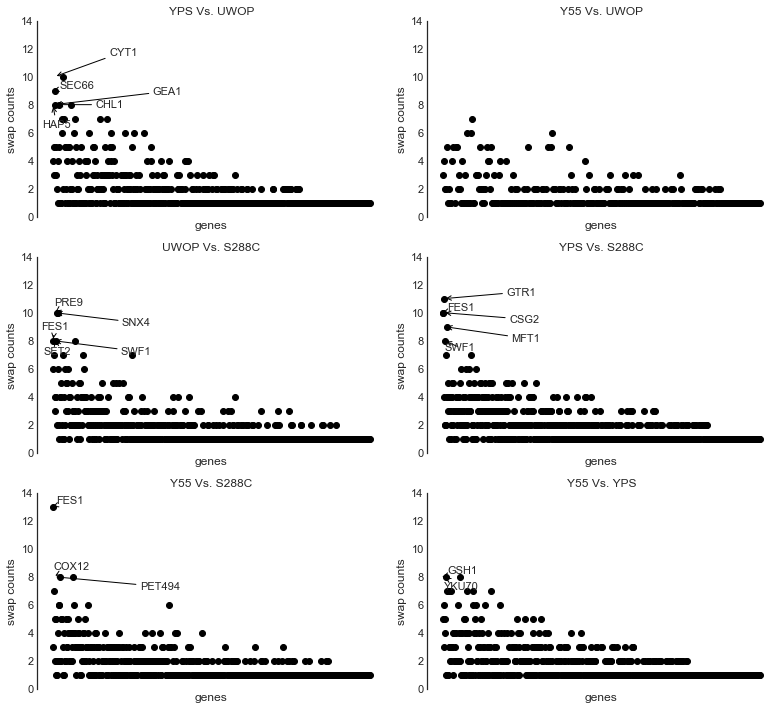

In [40]:
plt.figure(figsize=(11, 10))

i = 1
for s1, s2 in {tuple(x[:2])
               for x in d.index}:
    plt.subplot(3, 2, i)
    
    v = d.loc[(s1, s2), ].reset_index().set_index('gene').loc[genes]
    v = v[v['qval'] < 0.01].groupby('gene').count()['qval']
    v = v.reindex(idx).dropna()
    
    plt.plot(range(v.shape[0]),
         v,
         'ko')

    plt.ylim(0, 14)
    
    texts = [plt.text(i, y, gn.get(x, x),
                      ha='left',
                      va='center')
             for i,(x,y) in enumerate(v[v >= 8].iteritems())]
    adjust_text(texts,
                arrowprops=dict(arrowstyle='->',
                                color='k'),
                force_text=1.5)
    
    plt.xticks([])
    plt.ylabel('swap counts')
    plt.xlabel('genes')
    plt.title('%s Vs. %s' % (s1, s2))
    
    i += 1

plt.tight_layout()
sns.despine(bottom=True)

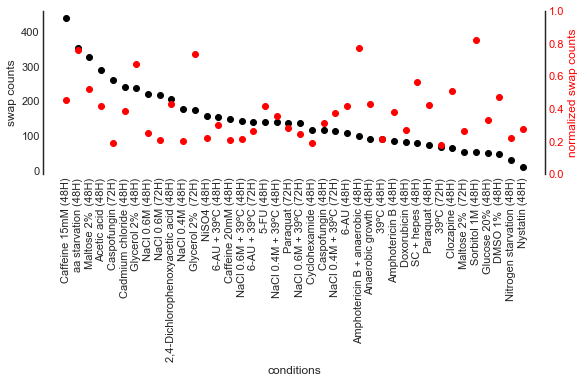

In [17]:
v = d.reset_index().set_index('gene').loc[genes]
v = v[v['qval'] < 0.01].groupby('condition').count()['qval'].sort_values(ascending=False)
idx = v.index

plt.figure(figsize=(9, 3))

plt.plot(range(v.shape[0]),
         v,
         'ko')

plt.xticks(range(v.shape[0]),
           v.index,
           rotation=90)
plt.ylabel('swap counts')
plt.xlabel('conditions')

plt.twinx()
plt.plot(range(v.shape[0]),
         v / p.loc[idx],
         'ro')

plt.tick_params('y', colors='r')
plt.ylabel('normalized swap counts',
           color='r')
plt.ylim(0, 1)

sns.despine(right=False,
            bottom=True);

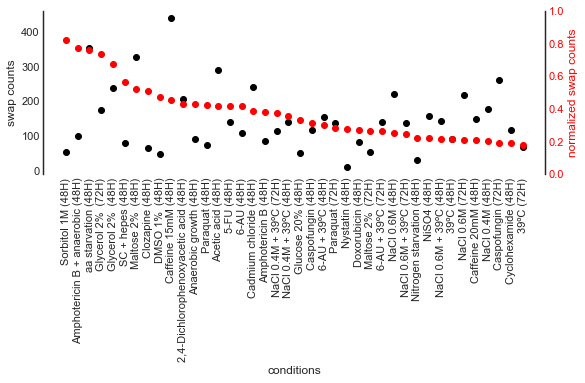

In [18]:
v = d.reset_index().set_index('gene').loc[genes]
v = v[v['qval'] < 0.01].groupby('condition').count()['qval'].sort_values(ascending=False)
idx = v.index
v1 = v / p.loc[idx]
v1 = v1.sort_values(ascending=False)
idx = v1.index
v = v.loc[idx]


plt.figure(figsize=(9, 3))

plt.plot(range(v.shape[0]),
         v,
         'ko')

plt.xticks(range(v.shape[0]),
           v.index,
           rotation=90)
plt.ylabel('swap counts')
plt.xlabel('conditions')

plt.twinx()
plt.plot(range(v.shape[0]),
         v / p.loc[idx],
         'ro')

plt.tick_params('y', colors='r')
plt.ylabel('normalized swap counts',
           color='r')
plt.ylim(0, 1)

sns.despine(right=False,
            bottom=True);

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1367: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


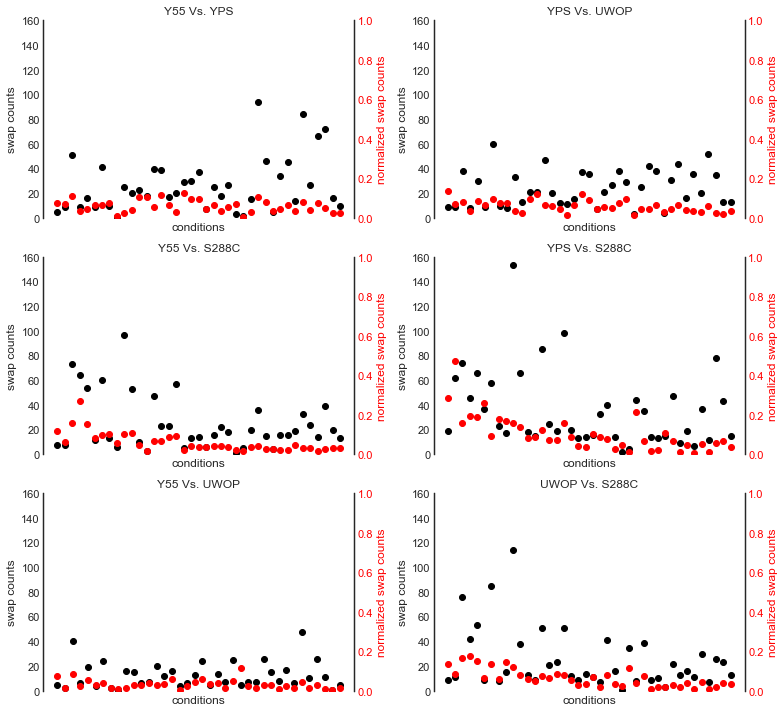

In [19]:
plt.figure(figsize=(11, 10))

i = 1
for s1, s2 in {tuple(x[:2])
               for x in d.index}:
    plt.subplot(3, 2, i)
    
    v = d.loc[(s1, s2), ].reset_index().set_index('gene').loc[genes]
    v = v[v['qval'] < 0.01].groupby('condition').count()['qval']
    v = v.reindex(idx).dropna()
    
    plt.plot(range(v.shape[0]),
         v,
         'ko')

    plt.ylim(0, 160)
    
    plt.xticks([])
    plt.ylabel('swap counts')
    plt.xlabel('conditions')
    
    plt.twinx()
    plt.plot(range(v.shape[0]),
             v / p.loc[v.index],
             'ro')

    plt.tick_params('y', colors='r')
    plt.ylabel('normalized swap counts',
               color='r')
    plt.ylim(0, 1)
    
    plt.title('%s Vs. %s' % (s1, s2))
    
    i += 1

plt.tight_layout()
sns.despine(right=False,
            bottom=True);